In [1]:
import os


In [2]:
%pwd

'c:\\Users\\ikbal\\Desktop\\projects\\flower-classification\\research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'c:\\Users\\ikbal\\Desktop\\projects\\flower-classification'

In [5]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class TrainingConfig:
    root_dir: Path
    trained_model_path: Path
    updated_base_model_path: Path
    training_data: Path
    params_epochs: int
    params_batch_size: int
    params_is_augmentation: bool
    params_image_size: list



@dataclass(frozen=True)
class PrepareCallbacksConfig:
    root_dir: Path
    tensorboard_root_log_dir: Path
    checkpoint_model_filepath: Path

In [6]:
from cnnClassifier.constants import *
from cnnClassifier.utils.common import read_yaml, create_directories
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [7]:
class ConfigurationManager:
    def __init__(
        self, 
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        create_directories([self.config.artifacts_root])


    
    def get_prepare_callback_config(self) -> PrepareCallbacksConfig:
        config = self.config.prepare_callbacks
        model_ckpt_dir = os.path.dirname(config.checkpoint_model_filepath)
        create_directories([
            Path(model_ckpt_dir),
            Path(config.tensorboard_root_log_dir)
        ])

        prepare_callback_config = PrepareCallbacksConfig(
            root_dir=Path(config.root_dir),
            tensorboard_root_log_dir=Path(config.tensorboard_root_log_dir),
            checkpoint_model_filepath=Path(config.checkpoint_model_filepath)
        )

        return prepare_callback_config
    




    def get_training_config(self) -> TrainingConfig:
        training = self.config.training
        prepare_base_model = self.config.prepare_base_model
        params = self.params
        training_data = os.path.join(self.config.data_ingestion.unzip_dir, "train")
        create_directories([
            Path(training.root_dir)
        ])

        training_config = TrainingConfig(
            root_dir=Path(training.root_dir),
            trained_model_path=Path(training.trained_model_path),
            updated_base_model_path=Path(prepare_base_model.updated_base_model_path),
            training_data=Path(training_data),
            params_epochs=params.EPOCHS,
            params_batch_size=params.BATCH_SIZE,
            params_is_augmentation=params.AUGMENTATION,
            params_image_size=params.IMAGE_SIZE
        )

        return training_config

In [8]:
import time

In [9]:
class PrepareCallback:
    def __init__(self, config: PrepareCallbacksConfig):
        self.config = config


    
    @property
    def _create_tb_callbacks(self):
        timestamp = time.strftime("%Y-%m-%d-%H-%M-%S")
        tb_running_log_dir = os.path.join(
            self.config.tensorboard_root_log_dir,
            f"tb_logs_at_{timestamp}",
        )
        return tf.keras.callbacks.TensorBoard(log_dir=tb_running_log_dir)
    

    @property
    def _create_ckpt_callbacks(self):
        return tf.keras.callbacks.ModelCheckpoint(
            filepath=str(self.config.checkpoint_model_filepath),
            save_best_only=True
        )


    def get_tb_ckpt_callbacks(self):
        return [
            self._create_tb_callbacks,
            self._create_ckpt_callbacks
        ]


In [10]:
import os
import urllib.request as request
from zipfile import ZipFile
import tensorflow as tf
import time
import numpy as np
from PIL import Image


In [11]:
train_data_dir =  "train"
test_data_dir = "test"

In [12]:
class Training:
    def __init__(self, config: TrainingConfig):
        self.config = config
    
    def get_base_model(self):
        self.model = tf.keras.models.load_model(
            self.config.updated_base_model_path
        )

    def get_trained_model(self):
        self.model = tf.keras.models.load_model(
            self.config.trained_model_path
        )

    def convert_images_to_rgb(self):
        def verify_and_convert_images(directory, target_mode='RGB'):
            for root, _, files in os.walk(directory):
                for file in files:
                    if file.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png')):
                        file_path = os.path.join(root, file)
                        try:
                            with Image.open(file_path) as img:
                                if img.mode not in ["RGB", "RGBA", "L"]:
                                    # print(f"Invalid color mode: {img.mode} for image: {file_path}")
                                    # Convert to the target mode
                                    img = img.convert(target_mode)
                                    img.save(file_path)
                        except (IOError, SyntaxError) as e:
                            print(f"Invalid image found: {file_path} - {e}")
                            os.remove(file_path)  # Optionally remove the corrupted file

        # Verify and convert images in train and test directories
        verify_and_convert_images(train_data_dir, target_mode='RGB')
        verify_and_convert_images(test_data_dir, target_mode='RGB')


    def read_data(self):
        img_height = 28
        img_width = 28
        batch_size = self.config.params_batch_size
        seed_train_validation = 1 # Must be same for train_ds and val_ds
        shuffle_value = True

        train_generator = tf.keras.utils.image_dataset_from_directory(
            directory = train_data_dir,
            image_size = (img_height, img_width),
            seed = seed_train_validation,
            shuffle = shuffle_value,
            labels='inferred',
            label_mode='int',
            ) # set as training data

        validation_generator = tf.keras.utils.image_dataset_from_directory(
            directory = test_data_dir,
            image_size = (img_height, img_width),
            seed = seed_train_validation,
            shuffle = shuffle_value,
            labels='inferred',
            label_mode='int',
        ) # set as validation data


        # Normalize the datasets
        normalization_layer = tf.keras.layers.Rescaling(1./255)

        self.train_generator_norm = train_generator.map(lambda x, y: (normalization_layer(x), y))
        self.validation_generator_norm = validation_generator.map(lambda x, y: (normalization_layer(x), y))


        # Split the validation dataset into test and validation datasets
        train_batches = tf.data.experimental.cardinality(self.train_generator_norm)
        self.train_ds = self.train_generator_norm.take((3 * train_batches) // 4)
        self.val_ds = self.train_generator_norm.skip((3 * train_batches) // 4)

        plt.figure(figsize=(15, 15))
        for images, labels in self.train_ds.take(1):
            print(images.shape, labels.shape)
            for i in range(10):
                ax = plt.subplot(5, 5, i + 1)
                plt.imshow(images[i].numpy())
                plt.title(train_generator.class_names[labels[i]])
                plt.axis("off")
        plt.show()


    @staticmethod
    def save_model(path: Path, model: tf.keras.Model):
        model.save(path)


    def train(self, callback_list: list):
        # Check if a GPU is available and set the device accordingly
        if tf.test.gpu_device_name():
            print('GPU found')
            device = '/device:GPU:0'  # Use the first GPU
        else:
            print('No GPU found')
            device = '/device:CPU:0'

        with tf.device(device):
            # self.model.fit(
            #     self.train_generator,
            #     epochs=self.config.params_epochs,
            #     steps_per_epoch=self.steps_per_epoch,
            #     validation_steps=self.validation_steps,
            #     validation_data=self.valid_generator,
            #     callbacks=callback_list
            # )

            history = self.model.fit(self.train_ds, validation_data=self.val_ds, epochs=self.config.params_epochs)
            self.save_model(
                path=self.config.trained_model_path,
                model=self.model
            )

    def test(self):
        test_loss, test_accuracy = self.model.evaluate(self.validation_generator_norm)
        print(f"Test accuracy: {test_accuracy}")

    def predict(self):
        # Collect images and labels from the dataset
        images_list = []
        labels_list = []

        for images, labels in self.validation_generator_norm:
            images_list.append(images.numpy())
            labels_list.append(labels.numpy())

        # Convert lists to NumPy arrays
        X = np.concatenate(images_list, axis=0)
        y = np.concatenate(labels_list, axis=0)

        # Run predictions
        predictions = self.model.predict(X)

        # Convert predictions to class labels
        predicted_labels = np.argmax(predictions, axis=1)

        # Convert true labels from one-hot encoded vectors to class labels
        true_labels = y

        # Calculate accuracy
        accuracy = np.mean(predicted_labels == true_labels)

        print(f"Accuracy: {accuracy * 100:.2f}%")

[2024-08-04 23:14:52,610: INFO: common: yaml file: config\config.yaml loaded successfully]
[2024-08-04 23:14:52,622: INFO: common: yaml file: params.yaml loaded successfully]
[2024-08-04 23:14:52,625: INFO: common: created directory at: artifacts]
[2024-08-04 23:14:52,628: INFO: common: created directory at: artifacts\prepare_callbacks\checkpoint_dir]
[2024-08-04 23:14:52,632: INFO: common: created directory at: artifacts\prepare_callbacks\tensorboard_log_dir]
[2024-08-04 23:14:52,636: INFO: common: created directory at: artifacts\training]
Found 60000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
(32, 28, 28, 3) (32,)


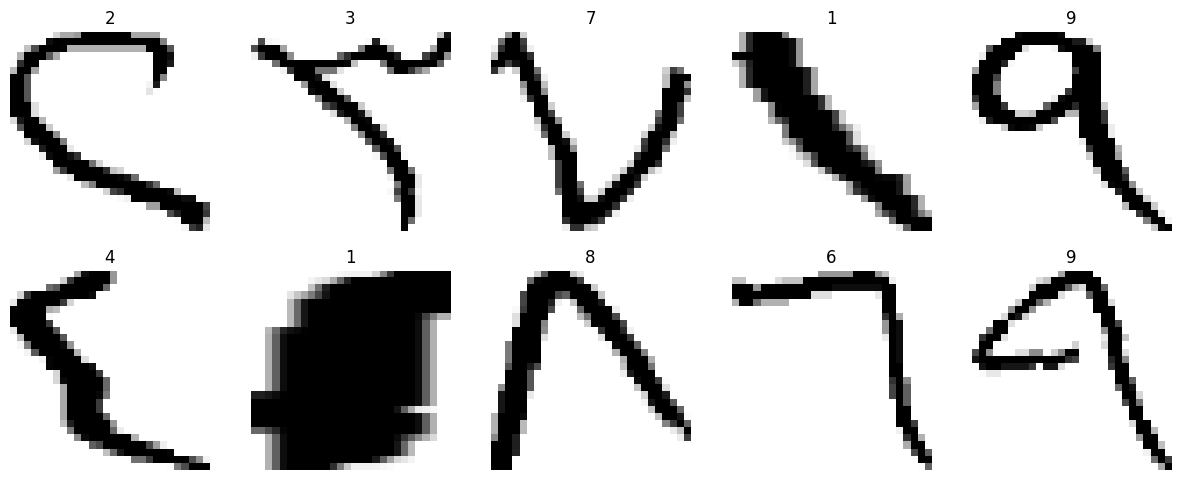

No GPU found
1406/1406 [==============================] - 126s 88ms/step - loss: 0.1286 - accuracy: 0.0991 - val_loss: 0.0458 - val_accuracy: 0.0910


c:\Users\ikbal\Desktop\projects\flower-classification\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
try:
    config = ConfigurationManager()
    prepare_callbacks_config = config.get_prepare_callback_config()
    prepare_callbacks = PrepareCallback(config=prepare_callbacks_config)
    callback_list = prepare_callbacks.get_tb_ckpt_callbacks()

    training_config = config.get_training_config()
    training = Training(config=training_config)
    training.get_base_model()
    training.convert_images_to_rgb()
    training.read_data()
    training.train(
        callback_list=callback_list
    )
    # training.get_trained_model()
    # training.test()
    # training.predict()
    
except Exception as e:
    raise e

In [14]:
training.get_trained_model()
training.test()
training.predict()

144/313 [============>.................] - ETA: 5s - loss: 0.0632 - accuracy: 0.0914

313/313 [==============================] - 10s 29ms/step - loss: 0.0597 - accuracy: 0.0930
Test accuracy: 0.09300000220537186
313/313 [==============================] - 4s 11ms/step
Accuracy: 98.32%
